# **Kinetic Model: Relative reaction rate of garnet core and rim in ZS-21-02**

This jupyter notebook provides the code to reproduce figure 4.


In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from tqdm.notebook import tqdm
from scipy.interpolate import RegularGridInterpolator

from pytheriak import wrapper

In [2]:
# Set-up TherCaller object, see https://github.com/Theriak-Domino/pytheriak
theriak = wrapper.TherCaller(programs_dir="C:\\TheriakDominoWIN\\Programs",
                             database="tc55_ZS2102",
                             theriak_version="v2023.06.11")

## **Prepare model parameters and variables**

Set up *P*-*T* gridspace, define bulk rock composition in the theriak-domino format, create variables for measured and modelled garnet compostion as well as the $\Delta G$.

In [3]:
P_min_bar = 8000
P_max_bar = 28000
P_step_bar = 500

T_min_C = 450
T_max_C = 650
T_step_C = 10

P_grid, T_grid = np.meshgrid(np.arange(start=P_min_bar, stop=P_max_bar + P_step_bar, step=P_step_bar),
                             np.arange(start=T_min_C, stop=T_max_C + T_step_C, step=T_step_C))

bulk_ZS2102 = "SI(0.864387)TI(0.017710)AL(0.315609)FE(0.120558)MN(0.001755)MG(0.167063)CA(0.184555)NA(0.136238)K(0.006467)H(0.5)O(?)"

In [4]:
core_Xprp = 0.03
core_Xalm = 0.40
core_Xgrs = 0.35
core_Xsps = 0.21

rim_Xprp = 0.10
rim_Xalm = 0.67
rim_Xgrs = 0.22
rim_Xsps = 0.02

eq_garnet_Xprp = []
eq_garnet_Xalm = []
eq_garnet_Xgrs = []
eq_garnet_Xsps = []

dG_core = []
dG_mantle = []
dG_rim = []

PT_points = []

lws_stable = []

## **Run main loop for kinetic model**

Loop over all *P*-*T* points and calculate the stable garnet composition and $\Delta G$ of fixed garnet core and rim composition in ZS-21-02.

In [5]:
for pressure, temperature in tqdm(zip(P_grid.flatten(), T_grid.flatten())):
    rock, element_list = theriak.minimisation(pressure, temperature, bulk_ZS2102, return_failed_minimisation=True)

    # look for garnet in the names of the mineral assemblage
    garnet = [mineral for mineral in rock.mineral_assemblage if mineral.name.startswith("GARNET_")]
    garnet_stable = len(garnet) > 0

    if garnet_stable:
        garnet = garnet[0]
        eq_garnet_Xprp.append(garnet.endmember_fractions["pyrope"])
        eq_garnet_Xalm.append(garnet.endmember_fractions["almandine"])
        eq_garnet_Xgrs.append(garnet.endmember_fractions["grossular"])
        eq_garnet_Xsps.append(garnet.endmember_fractions["spessartine"])

        dG_core.append(rock.mineral_delta_G["Garnet_core"])
        dG_rim.append(rock.mineral_delta_G["Garnet_rim"])

        PT_points.append([pressure, temperature])

        # check if lawsonite is stable
        laws_stable = "lawsonite" in [mineral.name for mineral in rock.mineral_assemblage]
        if laws_stable:
            lws_stable.append(True)
        else:
            lws_stable.append(False)

eq_garnet_Xprp = np.array(eq_garnet_Xprp)
eq_garnet_Xalm = np.array(eq_garnet_Xalm)
eq_garnet_Xgrs = np.array(eq_garnet_Xgrs)
eq_garnet_Xsps = np.array(eq_garnet_Xsps)

dG_core = np.array(dG_core)
dG_rim = np.array(dG_rim)

dG_core = np.array(dG_core)
dG_rim = np.array(dG_rim)

DELTA_G = dG_core - dG_rim

PT_points = np.array(PT_points)

laws_stable = np.array(lws_stable)

0it [00:00, ?it/s]

    450    21000
1   SI(0.864387)TI(0.017710)AL(0.315609)FE(0.120558)MN(0.001755)MG(0.167063)CA(0.184555)NA(0.136238)K(0.006467)H(0.5)O(?)    *
    450    22500
1   SI(0.864387)TI(0.017710)AL(0.315609)FE(0.120558)MN(0.001755)MG(0.167063)CA(0.184555)NA(0.136238)K(0.006467)H(0.5)O(?)    *
    450    24500
1   SI(0.864387)TI(0.017710)AL(0.315609)FE(0.120558)MN(0.001755)MG(0.167063)CA(0.184555)NA(0.136238)K(0.006467)H(0.5)O(?)    *
    450    26500
1   SI(0.864387)TI(0.017710)AL(0.315609)FE(0.120558)MN(0.001755)MG(0.167063)CA(0.184555)NA(0.136238)K(0.006467)H(0.5)O(?)    *
    460    23000
1   SI(0.864387)TI(0.017710)AL(0.315609)FE(0.120558)MN(0.001755)MG(0.167063)CA(0.184555)NA(0.136238)K(0.006467)H(0.5)O(?)    *
    470    20500
1   SI(0.864387)TI(0.017710)AL(0.315609)FE(0.120558)MN(0.001755)MG(0.167063)CA(0.184555)NA(0.136238)K(0.006467)H(0.5)O(?)    *
    480    20500
1   SI(0.864387)TI(0.017710)AL(0.315609)FE(0.120558)MN(0.001755)MG(0.167063)CA(0.184555)NA(0.136238)K(0.006467)H(0.5)O(

Calculate the relative reaction rate of garnet core and rim:

$\Delta r_{\text{rel}} = \frac{1-e^{\frac{-\Delta G_i^{\text{core}}}{RT_i}}}{1-e^{\frac{-\Delta G_i^{\text{rim}}}{RT_i}}}$

In [6]:
R = 8.31446261815324

rel_reaction_rate_core_rim = (1 - np.exp(-dG_core / (R * PT_points[:, 1]))) / (1 - np.exp(-dG_rim / (R * PT_points[:, 1])))

## **Interpolate and plot results**

Use interpolation to claculate a continous map of relative reactions rates in *P*-*T* space and plot the results.

In [7]:
rgi = RegularGridInterpolator((T_grid[:, 0].flatten(), P_grid[0].flatten()), np.reshape(rel_reaction_rate_core_rim, T_grid.shape))

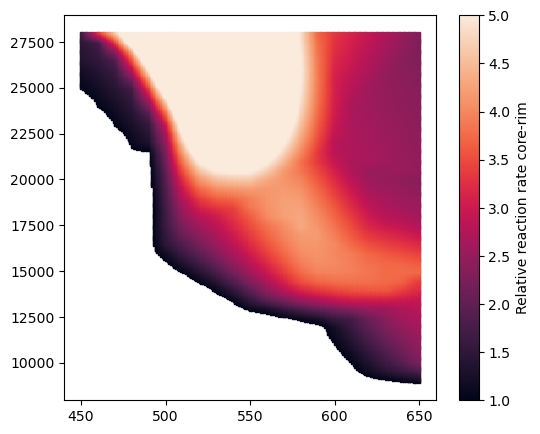

In [8]:
P_grid_new, T_grid_new = np.meshgrid(np.arange(start=P_min_bar, stop=P_max_bar + P_step_bar/10, step=P_step_bar/10), np.arange(start=T_min_C, stop=T_max_C + T_step_C/10, step=T_step_C/10))
# P_grid_new, T_grid_new = np.meshgrid(np.arange(start=P_min_bar, stop=20000 + P_step_bar/10, step=P_step_bar/10), np.arange(start=T_min_C, stop=T_max_C + T_step_C/10, step=T_step_C/10))
int_DELTA_G = rgi((T_grid_new, P_grid_new))

fig, ax = plt.subplots(figsize=(6, 5))



ax.scatter(T_grid_new[int_DELTA_G >= 1].flatten(), P_grid_new[int_DELTA_G >= 1].flatten(), c=int_DELTA_G[int_DELTA_G >= 1].flatten(), cmap=sns.color_palette("rocket", as_cmap=True), s=0.8, marker="s")
# adjust colorbar range
ax.collections[0].set_clim(1, 5)
fig.colorbar(ax.collections[0], ax=ax, label="Relative reaction rate core-rim")

plt.show()